# Track 2: LLM Stack Hackathon Data Analytics

In [1]:
import ast
import os
import json

import openai
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA


load_dotenv()


openai.organization = os.getenv("OPENAI_ORG")
openai.api_key = os.getenv("OPENAI_API_KEY")
# Point to your self-hosted redis server OR try a free redis cloud server from https://redis.com/try-free/
REDIS_URL = os.getenv("REDIS_URL")

try:
    openai.Model.list()
except:
    print("OpenAI authentication error")


## 1. Loading and Preprocessing Chat Data

In [2]:
# Each conversation grouped into a single thread_id
chats_df = pd.read_csv("../data/chats.csv")
chats_df.head()

,Unnamed: 0,channel_name,thread_id,chat_text
0,0,africa,2022-03-22 19:42:06.219769 UTC,U024WRAA0D9: Hello fellow MLOpsers in Africa :...
1,1,africa,2022-03-24 08:14:33.140029 UTC,U024WRAA0D9: What should our next steps be (fo...
2,2,africa,2022-03-28 11:57:42.840049 UTC,U024WRAA0D9: What’s everyone’s timezone?U024WR...
3,3,africa,2022-04-12 14:36:00.144498 UTC,U03142DQP6Z: Please can we make it later in th...
4,4,africa,2022-04-19 10:24:57.455849 UTC,"U024WRAA0D9: Hello <#C037GTG932B|africa>, I on..."


In [3]:
# The embedding for each conversation with its thread_id (Note: not all embeddings were generated for the chat text)
embeddings_df = pd.read_csv("../data/chats-embeddings-ada-002.csv")
embeddings_df.head()

,Unnamed: 0,thread_id,embedding
0,0,2022-03-22 19:42:06.219769 UTC,"[0.0036350293084979057, -0.01264416053891182, ..."
1,1,2022-03-24 08:14:33.140029 UTC,"[-0.002360287122428417, -0.04199115186929703, ..."
2,2,2022-03-28 11:57:42.840049 UTC,"[0.017543835565447807, 0.0032007887493819, 0.0..."
3,3,2022-04-12 14:36:00.144498 UTC,"[-0.001173610333353281, -0.014446504414081573,..."
4,4,2022-04-19 10:24:57.455849 UTC,"[-0.0025763490702956915, -0.02925489842891693,..."


In [5]:
df = pd.merge(
    chats_df,
    embeddings_df,
    left_on=['thread_id'],
    right_on=['thread_id'],
    how='left'
)
df = df[['thread_id', 'chat_text', 'embedding']]
df = df.set_index('thread_id')
df = df[df['embedding'].notna()]
df['embedding'] = df['embedding'].apply(ast.literal_eval)

In [124]:
df.head()

,chat_text,embedding,cluster,pca_1,pca_2
thread_id,,,,,
2022-03-22 19:42:06.219769 UTC,U024WRAA0D9: Hello fellow MLOpsers in Africa :...,"[0.0036350293084979057, -0.01264416053891182, ...",1,0.197534,0.084595
2022-03-24 08:14:33.140029 UTC,U024WRAA0D9: What should our next steps be (fo...,"[-0.002360287122428417, -0.04199115186929703, ...",1,0.127139,0.051428
2022-03-28 11:57:42.840049 UTC,U024WRAA0D9: What’s everyone’s timezone?U024WR...,"[0.017543835565447807, 0.0032007887493819, 0.0...",1,0.215497,-0.093326
2022-04-12 14:36:00.144498 UTC,U03142DQP6Z: Please can we make it later in th...,"[-0.001173610333353281, -0.014446504414081573,...",1,0.254545,-0.122308
2022-04-19 10:24:57.455849 UTC,"U024WRAA0D9: Hello <#C037GTG932B|africa>, I on...","[-0.0025763490702956915, -0.02925489842891693,...",1,0.211506,0.009015


## 2. K Means Clustering

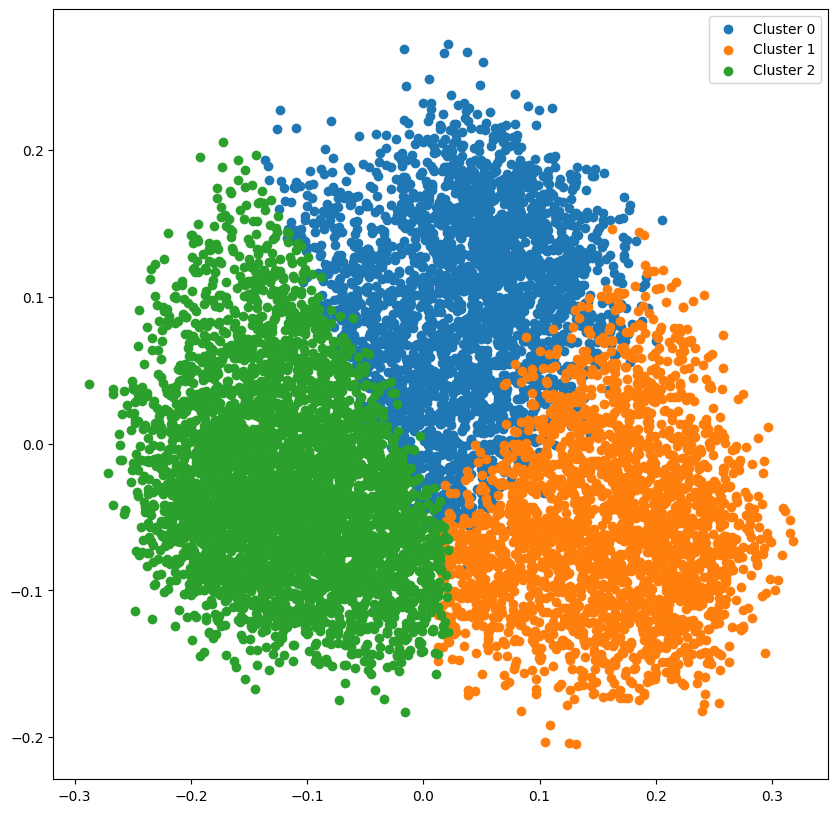

In [14]:
vectors = df['embedding'].tolist()

# Step 2: Use KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto').fit(vectors)

# Step 3: Add the labels to your DataFrame
df['cluster'] = kmeans.labels_

# Step 4: Plotting

pca = PCA(n_components=2)
pca_result = pca.fit_transform(vectors)

df['pca_1'] = pca_result[:,0]
df['pca_2'] = pca_result[:,1]

# plot each cluster
plt.figure(figsize=(10,10))

for cluster in set(kmeans.labels_):
    mask = df['cluster'] == cluster
    plt.scatter(df[mask]['pca_1'], df[mask]['pca_2'], label=f'Cluster {cluster}')

plt.legend()
plt.show()


In [96]:
cluster_size = df['cluster'].value_counts().to_dict()

## 3. Topic Modeling

In [123]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/han/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/han/nltk_data...


True

In [125]:
# Step 1: Preprocessing
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in df[df['cluster']==0]['chat_text']]

# Step 2: Prepare Document-Term Matrix
dictionary = Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# Step 3: Train LDA model
lda = LdaModel(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

# Step 4: Print topics
topics = lda.print_topics(num_words=3)  # adjust as needed
for topic in topics:
    print(topic)

KeyboardInterrupt: 

In [117]:
texts = df[df['cluster'] == 2]['chat_text']\
    .sample(int(cluster_size[0]*0.01))\
    .apply(lambda x: x.split(' ', 1)[-1])

In [118]:
def get_themes(text):
    prompts = f"""
    Please try to write out three themes from the following chat dialogue. Return \
    the themes as a JSON object. An example JSON object would be:\

    {{
        "themes": ['Data Science', 'MLOps', 'DevOps']
    }}

    The followings are the dialogues:
    {text}
    """

    prompts = prompts[:4097]

    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": prompts}
        ]
    )
    themes = ast.literal_eval(completion['choices'][0]['message']['content'])['themes']
    
    return themes

In [119]:
texts.apply(get_themes)

SyntaxError: invalid syntax (<unknown>, line 1)

In [64]:
# result = ' || '.join(prompts)

result = df['chat_text'][0]

['MLOps', 'Community Building', 'Excitement']